In [2]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
from tqdm import tqdm
import datetime as dt
from collections import Counter
from time import time

# text processing
import spacy
nlp = spacy.load('de')
from  nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover
from lda_functions import dict_pruning, party_substituter, sparse_text

In [3]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_complete_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates1 = ['08-{:02d}'.format(i) for i in range(2,32)]
dates2 = ['09-{:02d}'.format(i) for i in range(1, 9)]
dates = dates1 + dates2

if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [4]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_complete_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [5]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_complete_lda_duples.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data_dup = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# LDA using gensim 

- take only with certin 'tags' from clean text: nouns, verbs, adverbs, adjectives
    - substitute party acronyms (SPD: sozialdemokraten, CDU: christdemokraten, CSU: christoziale, FDP: freidemokraten, Afd: pfannen(unfortunately, using 'alternative' as substitute might intervene with the commonly used word or even with the politically more leftist alternatives that are not quite punks yet; using some cooking tool should be save)) 
    - make them lower-case
    - take only words longer than 2 characters
    - stem them
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
- run through a couple of topics numbers and look at metrics: coherence score and model perplexity
    -> chose number of topics where metrics look best
- run lda on corpus, evaluate model and visualize it

In [6]:
save = False

path_com_corpus = '../Data/lda_nlp_stem_ccorpus_complete.pkl'
path_corpus = '../Data/lda_nlp_stem_corpus_complete.pkl'
path_dic = '../Data/lda_nlp_stem_dic_complete.pkl'

if save:
    text = all_data.loc[:, 'clean_text'].map(lambda x: x.lower()).map(party_substituter)

    document = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
    
    lengths = len(document)
    corpus_full = []
    tick = time()
    for i, term in enumerate(document):
        corpus_full.append(sparse_text(term, nlp))
        print('{}/{}'.format(i, lengths), end='\r')
        if i % 5000 == 0:
            t1 = (time() - tick)/60
            print('Took {:.2f} min for {} loops'.format(t1, i))
    print('The entire process took {:.2f} min'.format((time() - tick)/60))

    
    corpus = dict_pruning(corpus_full, 10)

    common_dictionary = corpora.Dictionary(corpus, prune_at=100000)

    common_corpus = [common_dictionary.doc2bow(row) for row in corpus]

    
    with open(path_com_corpus, 'wb') as fid:
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)       

else:
    with open(path_com_corpus, 'rb') as fid:
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)

<Figure size 720x2160 with 0 Axes>

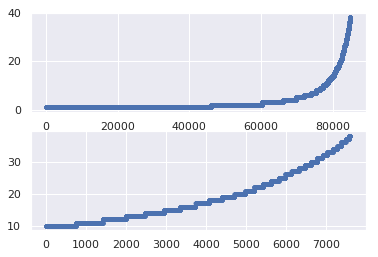

In [4]:
def corpus_wordcount(corpus, full_corpus):
    """
    visualizes how the number of low-frequency words changes after pruning the dictionary
    """
    
    flat_list = [item for sublist in corpus for item in sublist]
    full_flat_list = [item for sublist in full_corpus for item in sublist]
    cntr = Counter(flat_list)
    full_cntr = Counter(full_flat_list)
    
    fig = plt.figure(figsize=(10, 30))
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(sorted(full_cntr.values())[:-5000], '.')
    ax2.plot(sorted(cntr.values())[:-5000], '.')
    plt.show()

corpus_wordcount(corpus=corpus, full_corpus=corpus_full)

In [ ]:
def document_wordcount(corpus, full_corpus):
    """
    visualizes how long the tweets are before and after pruning the dictionary
    """
    
    plt.hist([len(x) for x in corpus], bins=np.linspace(0,20,20), label='Pruned corpus')
    plt.hist([len(x) for x in full_corpus], bins=np.linspace(0,20,20), label='Full corpus', alpha=0.5)
    plt.legend()
    plt.show()

document_wordcount(corpus=corpus, full_corpus=corpus_full)

/home/franzi/miniconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



Process took 10.596585742632548 min


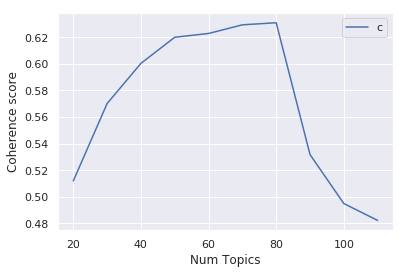

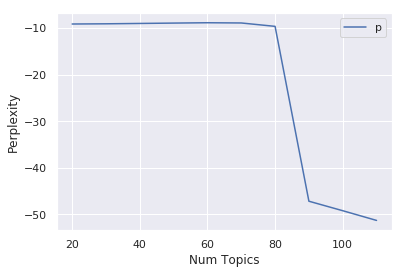

In [70]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    tick = time()
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.2,
                       iterations=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(common_corpus))
    print('Process took {} min'.format((time()-tick)/60))
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    plt.plot(x, perplexity_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity")
    plt.legend(("perplexity"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=120, start=20, step=10)

Following from coherence score curve
- choose 22 topics: highest coherence score before curve flattens out 
- given the corpus 20 topics make more sense than 80 - this can also be seen in the LDA visualization: with 80 topics, most of them cluster in the lower-right corner

Following from LDA visualization
- comparing topic-bubbles of different numbers of topics: chosing 17 topics results in nicely distributed, hardly overlapping clusters

In [6]:
lda = LdaModel(common_corpus, 
               num_topics=84, 
               id2word=common_dictionary, 
               alpha=0.001,
               passes=5,
               random_state=123, 
               minimum_probability=0.2,
               per_word_topics=True,
               iterations=70)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score c_v:  0.5174928241691445
Coherence Score u-mass:  -16.11884076916283
Model perplexity:  -49.22550065650407


/home/franzi/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [7]:
save_model = False
path = '../Models/lda_nlp_stemmed_lda-model_complete.pkl'
if save_model:
    with open(path, 'wb') as fid:
        pickle.dump(lda, fid)
else:
    with open(path, 'rb') as fid:
        lda = pickle.load(fid)

In [8]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [8]:
save_topics = False
path = '../Data/lda_nlp_stemmed_lda_topics_complete.pkl'

if save_topics:   
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)
    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    
    # reindex the initial dataframe, make list of initial df and topics df and concatenate both
    all_data_reindexed = all_data.reset_index(drop=True)
    df_list = [df_dominant_topic,all_data_reindexed]
    full_df = pd.concat(df_list, axis=1)
    # make the resulting dataframe datetime indexed again and throw away unwanted columns
    full_df.index = full_df['created_at']
    full_df['topic'] = full_df['Dominant_Topic'].map(lambda x: x.replace('nan', np.NaN) if isinstance(x, str) else x)
    full_df = full_df.drop(['stemmed', 'tags', 'parties', 'created_at', 'mentions'], axis=1)
    # show
    full_df.head()

    with open(path, 'wb') as fid:
        pickle.dump(full_df, fid)

else:
    with open(path, 'rb') as fid:
        full_df = pickle.load(fid)

In [28]:
all_merged = all_data_dup.merge(full_df, on='clean_text', ).set_index('created_at').drop(['full_text_y', 'user_id_y'], axis=1)

In [29]:
all_merged.head()

,full_text_x,tags,mentions,clean_text,parties,stemmed,user_id_x,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic
created_at,,,,,,,,,,,,,
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,0,60.0,0.4139,"christsozial, soed, seehof, frau, bayer, wahlk...","[migrant, fluechtling, christsozial, christsoz...",60.0
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,0,60.0,0.4139,"christsozial, soed, seehof, frau, bayer, wahlk...","[migrant, fluechtling, christsozial, christsoz...",60.0
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,0,60.0,0.4139,"christsozial, soed, seehof, frau, bayer, wahlk...","[migrant, fluechtling, christsozial, christsoz...",60.0
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,0,60.0,0.4139,"christsozial, soed, seehof, frau, bayer, wahlk...","[migrant, fluechtling, christsozial, christsoz...",60.0
2018-08-02 00:00:32,@bembelpix @AfD_Hessen NoAFD schreiben aber ke...,[],"[bembelpix, AfD_Hessen]",NoAFD schreiben aber keine Argumente li...,[AfD],noafd schreib aber kein argument lief ...,702527680722419712,1,21.0,0.4803,"heutig, argument, bekannt, muslim, anhaeng, li...","[nopfann, argument]",21.0


In [30]:
topic_counts_dup = all_merged.groupby(all_merged.index.date)['topic'].value_counts().reset_index(name='counts')
topic_counts_dup = topic_counts_dup.set_index(pd.DatetimeIndex(topic_counts_dup['level_0'])).drop(columns='level_0')

In [24]:
topic_counts = full_df.groupby(full_df.index.date)['topic'].value_counts().reset_index(name='counts')
topic_counts = topic_counts.set_index(pd.DatetimeIndex(topic_counts['level_0'])).drop(columns='level_0')

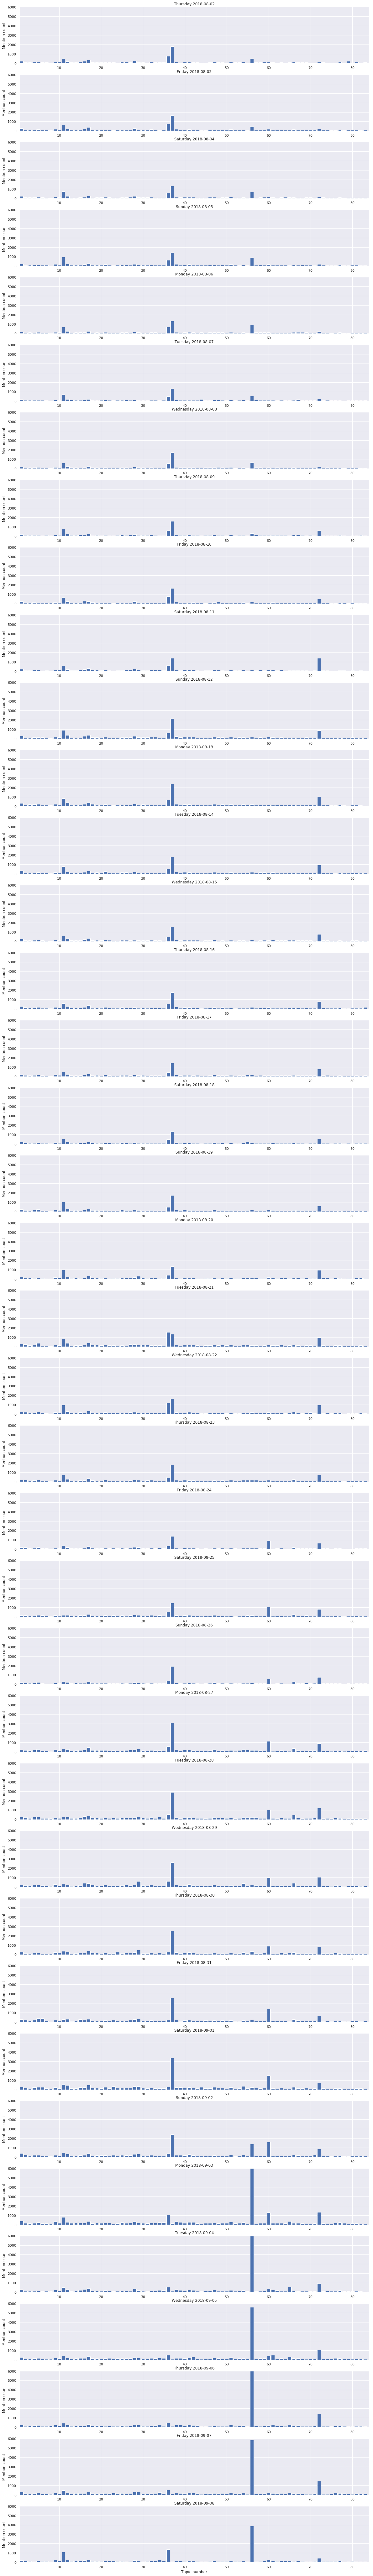

In [43]:
def topic_plot(df):
    dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dates = df.index.unique()
    
    fig, ax = plt.subplots(len(dates), 1, figsize=(20, 150))

    for i, date in enumerate(dates):
        ax[i].bar(df.loc[date, 'topic'], df.loc[date, 'counts'], label=date) 
        ax[i].set_ylim(0, 6000)
        ax[i].set_title('{} {}'.format(dow[date.dayofweek], date.date()))
        ax[i].set_ylabel('Mention count')
        ax[i].set_xlim(0.5, len(df['topic'].unique()))
    plt.xlabel('Topic number')
    plt.show()

# topic_plot(topic_counts)

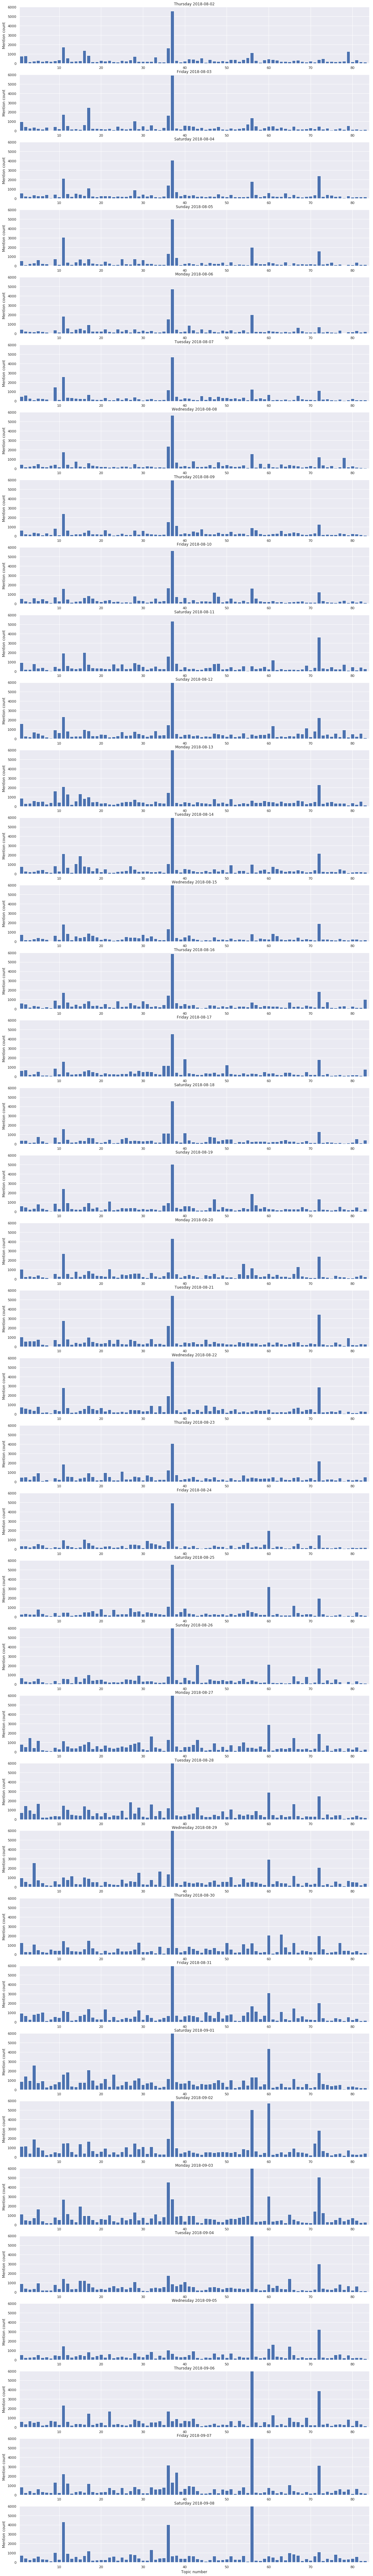

In [44]:
topic_plot(topic_counts_dup)

In [47]:
def print_largest_topics(topicsdf, fulldf, topic_prob=0.85, n_text=5):
    largest_tpcs = topicsdf.copy().reset_index().reset_index()
    frequent_topcs = largest_tpcs.groupby('level_0')['counts'].nlargest(5).reset_index().merge(
                 largest_tpcs[['index', 'topic']], left_on='level_1', right_on='index').drop(
                 columns='level_1')
    frequent_topcs_list = frequent_topcs.topic.unique()
    
    for topic in frequent_topcs_list:
        print('-'*150)
        print(topic, fulldf[['Keywords']][fulldf['topic'] == topic].values[0])
        print('-'*150)
        print(fulldf[['Topic_Perc_Contrib', 'clean_text']][(fulldf['topic'] == topic) & (fulldf['Topic_Perc_Contrib'] > topic_prob)].values[:n_text])

print_largest_topics(topic_counts_dup, all_merged, topic_prob=0.9, n_text=5)

------------------------------------------------------------------------------------------------------------------------------------------------------
37.0 ['pfann, journalist, muell, lesenswert, parlament, newslett, weimar, autoindustri, leit, fern']
------------------------------------------------------------------------------------------------------------------------------------------------------
[[0.9233999848365784
  '    LarsSteinke  aeussert  hier  eine  eigene    steile    These   Verquirlt  mit  ein  paar  abstrusen  Annahmen   Grundsaetzlich  geht  er  aber  in  die  richtige  Richtung   War   stauffenberg  wirklich  ein  Held   weil  er   Hitler  toeten  wollte  oder  wollte  er  nur  eine   sanfte  Landung   moeglich  machen  ']
 [0.9233999848365784
  '   Sein  Anwalt  erklaerte  nun  gegenueber  dem  ZDF   dass  der  Islamist   SamiA  nur  noch  auf  die  Ausstellung  seines  neuen  Reisepass  ']
 [0.9233999848365784
  '   Sein  Anwalt  erklaerte  nun  gegenueber  dem  ZDF

[[0.9233999848365784
  '    Rees   NRW   Inder  bietet    jaehrigem  Maedchen  spontan  Geld  fuer  Sex   fasst  sie  taetlich  an   Die  Staatsanwaltschaft  laesst  ihn  ']
 [0.9233999848365784
  '    Rees   NRW   Inder  bietet    jaehrigem  Maedchen  spontan  Geld  fuer  Sex   fasst  sie  taetlich  an   Die  Staatsanwaltschaft  laesst  ihn  ']
 [0.9233999848365784
  '    Rees   NRW   Inder  bietet    jaehrigem  Maedchen  spontan  Geld  fuer  Sex   fasst  sie  taetlich  an   Die  Staatsanwaltschaft  laesst  ihn  ']
 [0.9233999848365784
  '    Rees   NRW   Inder  bietet    jaehrigem  Maedchen  spontan  Geld  fuer  Sex   fasst  sie  taetlich  an   Die  Staatsanwaltschaft  laesst  ihn  ']
 [0.9233999848365784
  '    Rees   NRW   Inder  bietet    jaehrigem  Maedchen  spontan  Geld  fuer  Sex   fasst  sie  taetlich  an   Die  Staatsanwaltschaft  laesst  ihn  ']]
---------------------------------------------------------------------------------------------------------------------------------

40.0 ['artikel, falsch, abschaum, boes, reich, ohr, nopfann, eigent, googl, hessisch']
------------------------------------------------------------------------------------------------------------------------------------------------------
[[0.9233999848365784
  '  Geh  kacken    Tobias   Oder  kuemmert  euch  um  die  Witzfiguren  in  der  eigenen   Partei    Gute  Besserung  noch  ']
 [0.9233999848365784
  '   Ich  weiss   eure   gegen  Argumente  immune   AfD  Sektenwelt  kann  man  mit  der  Wahrheit  nicht  erreichen    Man  muss  es  schon  in  eine  rassistisch  diskriminierende  Umverpackung  stecken  damit  ihr  fuer  irgend  etwas  von  dem  gesagten  zugaenglich  seid    Da  dies  ein  Widerspruch  waere   keine  Chance ']
 [0.9233999848365784
  '  Die  AFD   muesste  versuchen   ein  Buergerentscheid  zu  organisieren  genauso  in  Koeln  Duesseldorf  und  Bonn   Kaufbeuren  sollte  ein  Beispiel  sein ']
 [0.9602000117301941
  ' CDU   CSU   AfD   SPD   Oesterreich   Schweiz 

[[0.9233999848365784
  '  Ein  Scheiss  tritt  in  Kraft   Die  ganzen  linken  Parteien  gehoeren  endlich  mal  weg  und  ausser  der  AfD  noch      andere  in  die  Parlamente  und  natuerlich  auch  in  den  BT  und  dann  werden  erstmal  grundlegende  Dinge  geaendert   Dinge  wie  diese  und  noch  mehr    traeumchen ']
 [0.9233999848365784
  '     Schonmal  von  Wohnungsnot   Lehrermangel   fehlenden  Kitaplaetzen  etc  gehoert   Finde  den  Zusammenhang   Dummerle       neue  Migranten   allein  fuer  Berlin   aber  keine  neuen  Aerzte   Lehrer   Wohnungen     Wie  bescheuert  muss  man  sein   da  noch  weiter  reinzuwinken  ']
 [0.9233999848365784
  'Das  beweist  einmal  mehr  welches  gefaehrliche  Denken  in  der   AfD  herrscht   Das  ist  nicht  anderes  als  voelkisch  und  nationalsozialistisch    niewieder   noAfD  einLink ']
 [0.9602000117301941
  'Das   SPD  gefuehrte   Regensburg  mit  Buergermeisterin  Gertrud  Maltz   Schwarzfischer  schliesst  sich  nun  auch

[[0.9233999848365784
  '   die  AfD  und  die  CSU  treten  also  geschlossen  zurueck   aufgrund  mangelnder  Authentizitaet   Lebenserfahrung  und  Buergernaehe   Das  ']
 [0.9233999848365784
  '   die  AfD  und  die  CSU  treten  also  geschlossen  zurueck   aufgrund  mangelnder  Authentizitaet   Lebenserfahrung  und  Buergernaehe   Das  ']
 [0.9602000117301941
  '  Es  wird  nicht  mit  Hitler  geworben   Das  ist  ein  wissenschaftliches  Buch   das  sich  mit  Geschichte  befasst   Hast  du  etwa  auch  was  gegen  den  Spiegel   Da  ist  Hitler  doch  staendig  auf  dem  Titelbild   Kein  Mensch  sehnt  sich  den  Nationalsozialismus  wieder  herbei   schon  gar  nicht  die  AfD  ']
 [0.9233999848365784
  'Lernt  man  heute  nicht  mehr  in  der  Schule   wirmdas  damals  war    einLink ']
 [0.9233999848365784
  '  Sehe  ich  auch  genau  so      Problem   willst  die  loswerden      bricht  bei  der  AfD  auch  Waehlerpotential  weg  ']]
----------------------------------------

[[0.9233999848365784
  '    Drittens  in  kauf  nehmen  ist  ungleich  wollen     Wenn  ich  also  bergsteige  nehme  ich  in  kauf  das  ich  abstuerze  und  sterbe  ich  will  deshalb  aber  nicht  abstuerzen  und  sterben ']
 [0.9233999848365784
  'Und  die   AfD   Niedersachsen  sieht  wieder  keinen  Anlass  zum  Handeln  wenn  Mitglieder  wie   Nazis  schreiben    ltnds  einLink ']
 [0.9731000065803528
  '  Dadurch   dass  die  AfD  die  einzige  Partei  ist   die  nach  ihrem  Selbstverstaendnis  diejenigen  vertritt   die  sich  selbst  als  Teil  des  DEUTSCHEN  Volkes  begreifen   und  nicht  als  irgendwelche  zufaellig  hier  geborene  angebliche  Individuen  mit  konstruierter  geschlechtlicher  Identitaet  ']
 [0.9602000117301941
  '  Die  Wahrheit  ist  auch   dass  die  AFD  rechtsextrem  ist  ']
 [0.9233999848365784
  ' Nein  haben  sie  nicht   nur  weil  die  AfD  die  Minderheit  hat   stimmt  es  nicht  immer   was  sie  sagen  kritisieren ']]
---------------------

In [80]:
full_df.loc[full_df['topic']==15]['2018-09-04']['clean_text'].values

array([' Die  Wanderung  zur  AfD  stoppen  und  vielleicht  umkehren   einLink ',
       'Es  ist  infam   wenn   Linke  Bundeslaender   Bremen   amp    Niedersachsen  den   Verfassungsschutz  gegen  die  freiheitlich  demokratische   AfD  Jugend  missbrauchen   um  der  politischen  Konkurrenz  Knueppel  zwischen  die  Beine  zu  werfen   Warum  werden   Gruene    Linke    SPD  oder   CDU  nicht  beobachtet  ',
       ' ZAeHNEPUTZEN  gegen   Hass  und   Hetze  Nase  popeln  gegen   Nazis  BUNNY  meint   Unsere   Wahrheits  Presse  bietet  super  Sportarten  zur  Staerkung  von   Weltoffenheit  und   Toleranz    Stern  Foto  Zitat     Rassismus   Steinmeier   Chemnitz   Wirsindmehr   Pegida   AFD   Campino   JungeAlternative  einLink ',
       ' Aufstehen  greift  laut  Neues  Deutschland  mit  Nationalismus  erhebliche  Waehlermengen  von  AfD  und  CDU  ab    A   Gute  Strategie  zur  Eindaemmung  der  Rechten  oder   B   Staerkung  rechter  Ideologien  ',
       '  Franziskas  Vate

In [81]:
lda.show_topic(32)

[('demokrat', 0.1923053),
 ('weiss', 0.13420774),
 ('derzeit', 0.11239642),
 ('fehl', 0.09379498),
 ('vorh', 0.07405561),
 ('einzeln', 0.0642303),
 ('oesterreich', 0.04638621),
 ('hos', 0.0434281),
 ('regier', 0.040331535),
 ('schweiz', 0.033285804)]